In [437]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy import ndimage

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Build the model (Sequential) by stacking layers.

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(10)
])

Up until now, the model returns a vector of *logits* for each class. 

In [50]:
predictions = model(x_train[:1]).numpy()
predictions


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[-0.36321512, -0.45045516, -0.17889068, -0.12810755,  0.42888498,
         0.22613856, -0.71261036,  0.39351085,  0.1339694 , -0.2840496 ]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class.

In [51]:
tf.nn.softmax(predictions).numpy()

array([[0.0716454 , 0.06565993, 0.08614685, 0.09063464, 0.1581951 ,
        0.12916397, 0.0505182 , 0.15269691, 0.11779119, 0.0775478 ]],
      dtype=float32)

For the loss calculation it is better to keep the model with logits, despite being more interpretable after applying the softmax function. 

In [52]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the the true class: It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.log(1/10) ~= 2.3`.

In [53]:
loss_fn(y_train[0], predictions).numpy()

2.0466726

Let's compile the model

In [54]:
model.compile(optimizer='adam', 
              loss=loss_fn, 
              metrics=['accuracy'])

In [55]:
x_train.shape

(60000, 28, 28)

The .fit method adjust the parameters to minimize the loss

In [316]:
model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1246 - accuracy: 0.9614
Epoch 2/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1201 - accuracy: 0.9627
Epoch 3/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.1184 - accuracy: 0.9635
Epoch 4/5
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1115 - accuracy: 0.9645
Epoch 5/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1085 - accuracy: 0.9657


Now we can check the model's performance with `Model.evaluate`

In [317]:
model.evaluate(x_test, y_test, verbose=2)

10000/10000 - 1s - loss: 0.0776 - accuracy: 0.9775


[0.07757314908283297, 0.9775]

To get probs we can wrap the model with a softmax function

In [318]:
prob_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [319]:
prob_model(x_test[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.15900248e-10, 1.49606984e-13, 3.91279791e-08, 1.42155941e-05,
        1.96000629e-15, 1.09697873e-09, 1.93532750e-20, 9.99985576e-01,
        2.61377586e-10, 1.05367434e-07]], dtype=float32)>

Let's calculate the predictions for all images:

In [320]:
predictions = prob_model.predict(x_test)

In [321]:
np.argmax(predictions[0])

7

In [322]:
y_test[0]

7

Let's use the same functions to plot the prediction and the true value for the data

In [323]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([]) 
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel('{} {:2.0f}% (true:{})'.format(predicted_label,
                                         100*np.max(predictions_array),
                                         true_label),
                                         color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

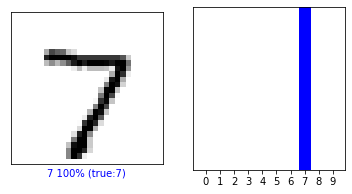

In [324]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], y_test)
plt.show()

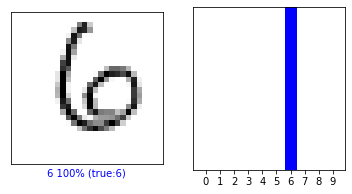

In [325]:
i = 100
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

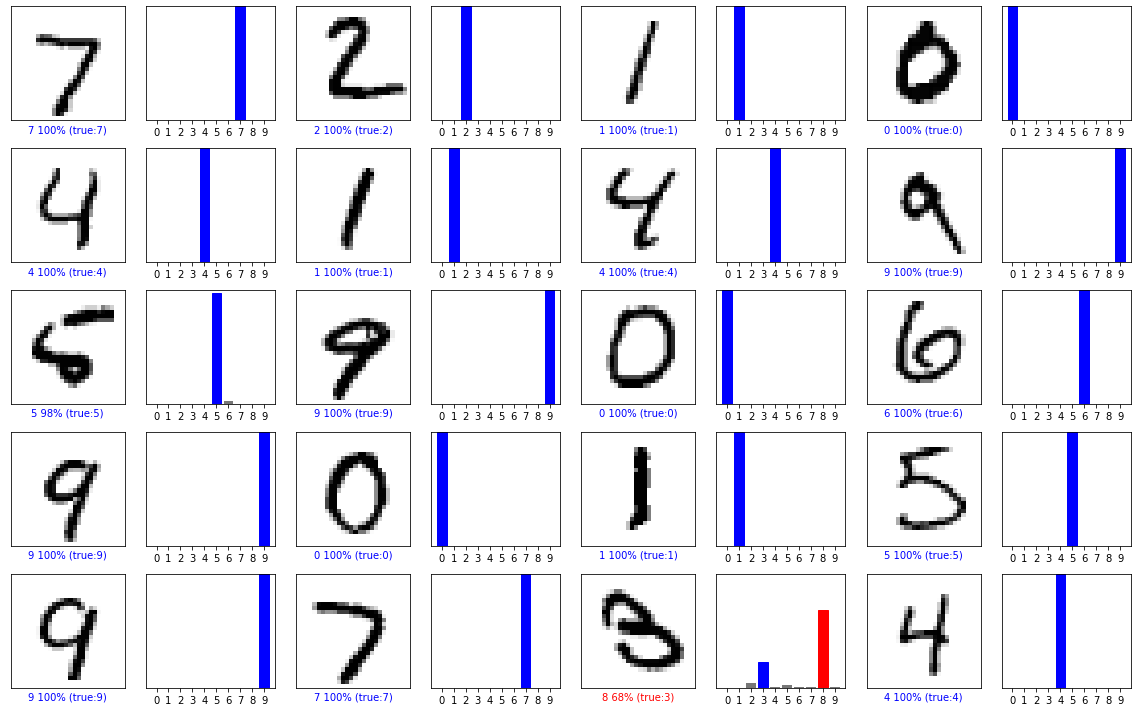

In [326]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

By changing the dropout range from 0.2 to 0.5, the prediction for image at position 8 improved. 

Now I want to use the model to predict a single image. 

In [327]:
image_pos = 97
image = x_test[image_pos]
print(image.shape)

(28, 28)


In [328]:
image = np.expand_dims(image, 0)
image.shape

(1, 28, 28)

In [329]:
single_prediction = prob_model.predict(image)
print(single_prediction)

[[2.5621356e-08 9.7658500e-05 1.0080033e-01 3.5131604e-03 9.4150458e-08
  3.2134281e-07 7.5964879e-09 8.9557362e-01 1.4707560e-05 3.1209998e-10]]


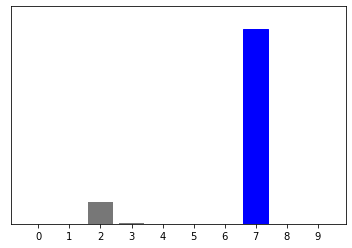

In [330]:
plot_value_array(image_pos, single_prediction[0], y_test)

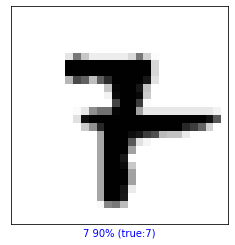

In [331]:
plot_image(image_pos, single_prediction[0], y_test, x_test)

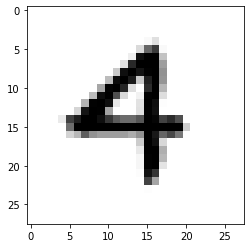

In [427]:
path_to_images = 'C:\\users\\fdoli\\github\\tensorflow\\selfmade_data\\'
path_image_1 = path_to_images + '4_1.png'

image_1 = cv2.imread(path_image_1, cv2.IMREAD_GRAYSCALE)
image_1 = cv2.resize(255-image_1, (28, 28), interpolation = cv2.INTER_AREA)
image_1 = image_1 / 255.0
plt.imshow(image_1, cmap=plt.cm.binary)  # graph it
plt.show()


image_1s = np.array(image_1).reshape(-1, 28, 28)

In [391]:
single_prediction = prob_model.predict(image_1s)
print(np.argmax(single_prediction))

9


Let's add the option to predict images of any size. 

In [335]:
image_read = cv2.imread(path_image_1, cv2.IMREAD_GRAYSCALE)
image_read = cv2.resize(255-image_read, (28, 28))
image_read = image_read / 255.0

In [336]:
image_read.shape

(28, 28)

In [449]:
def selfmade_read_image(image_name):
    path_to_images = 'C:\\users\\fdoli\\github\\tensorflow\\selfmade_data\\'
    path_image_read = path_to_images + image_name + '.png'
    
    image_read = cv2.imread(path_image_read, cv2.IMREAD_GRAYSCALE) # reading the image as grayscale
    image_read = cv2.resize(255-image_read, (28, 28), interpolation = cv2.INTER_AREA) # here I invert (0 background) and resize to an image of 28x28 
                                                                                      # using interpolation "Inter_Area" to get smoother images
    image_read = image_read / 255.0 # normalizing from 0 to 1 to match the training images
    return image_read


def selfmade_predict(image_read):    
  
    plt.imshow(image_read, cmap=plt.cm.binary)  # graph it
    image_read = np.array(image_read).reshape(-1, 28, 28) # this reshape is for the single prediction, since tensorflow wants "lists"
    single_prediction = prob_model.predict(image_read)    
    plt.xlabel('predicted: {} ({:2.0f}% prob)'.format(np.argmax(single_prediction), 100 * np.max(single_prediction)))
#     plt.show()
#     plot_value_array_selfmade(single_prediction[0])
    return single_prediction[0]

def plot_value_array_selfmade(predictions_array):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    plt
    
    thisplot[predicted_label].set_color('red')    
        
        
def centering_image(image):
    # First empty cols and rows are deleted
    while np.sum(image[0]) == 0:
        image = image[1:]
    
    while np.sum(image[:, 0]) == 0:
        image = np.delete(image, 0, 1)
    
    while np.sum(image[-1]) == 0:
        image = image[:-1]    
    
    while np.sum(image[:, -1]) == 0:
        image = np.delete(image, -1, 1)
    
    rows, cols = image.shape
    
    # Now the image is resized and zeros are added to the sides until bulding a 28x28 image
    colsPadding = (int(np.math.ceil((28-cols)/2.0)),int(np.math.floor((28-cols)/2.0)))
    rowsPadding = (int(np.math.ceil((28-rows)/2.0)),int(np.math.floor((28-rows)/2.0)))
    image = np.lib.pad(image, (rowsPadding, colsPadding), 'constant')
    return image

# Function to calculate center of maxx and the shift of the image 
def getBestShift(image):
    cy, cx = ndimage.measurements.center_of_mass(image) # calculating the center of mass

    rows, cols = image.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx, shifty    

# Function to shift the image using openCV
def shift(image, sx, sy):
    rows,cols = image.shape
    M = np.float32([[1, 0, sx], [0, 1, sy]]) # transformation matrix
    shifted = cv2.warpAffine(image, M, (cols, rows))
    return shifted

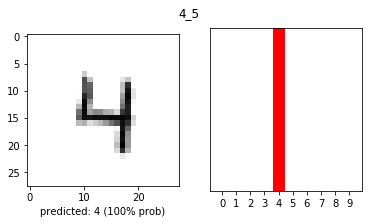

In [486]:
self_image_name = '4_5'

# we read the image
self_image = selfmade_read_image(self_image_name)

# Now we calculate the shift and apply the shift
shiftx, shifty = getBestShift(self_image)
shifted = shift(self_image, shiftx, shifty)
shifted_image = shifted # new image

plt.figure(figsize=(6, 3))
plt.suptitle(self_image_name)
plt.subplot(1, 2, 1)
sp = selfmade_predict(shifted_image)
plt.subplot(1, 2, 2)
plot_value_array_selfmade(sp)
plt.show()

It works better than before, specially with the image interpolation.  
*Current problem is that the training set consists of numbers centered in a 28x28 image, but the number itself is contained in a 20x20 box. We'll need to resize and center our selfmade images to match that specifications.  
For this mnist trainig dataset, images are centered using the "center of mass" technique.


### * After the changes:  
Now the image is resized and centered using the added functions